# 訓練資料量對解碼性能之影響

In [1]:
from model_tf import simpleDecodeModel
import numpy as np
import pandas as pd
import os
import itertools
from sklearn.metrics import r2_score
from dataPreprocess import read_dataset
from loss_functions import maximumMeanDiscrepancy

In [2]:
folderPath = './data' #################################
fileList = sorted([i for i in os.listdir(folderPath) if i.endswith('zip')])
trainCount = [938, 1875, 2813, 3750, 4688] # 1min, 2min, 3min, 4min, 5min

In [ ]:
for sessionIndex in range(37): # 
    sessionName = fileList[sessionIndex]
    sessionDataset = read_dataset(os.path.join(folderPath, sessionName), ['velocity_x', 'velocity_y'])

    for minute, cnt in enumerate(trainCount):
        minute += 1

        print(f'session= {sessionIndex+1}\ttrainLen= {minute} minute(s)')
        #
        train_x = sessionDataset['m1'][:cnt]
        train_y = sessionDataset['movement'][:cnt]
        test_x = sessionDataset['m1'][5000:]
        test_y = sessionDataset['movement'][5000:]

        # zScore
        movement_mean, movement_std = train_y.mean(), train_y.std()
        train_y = (train_y - movement_mean) / movement_std
        

        #
        model = simpleDecodeModel()
        model.compile(optimizer='adam', loss='mse')

        #
        model.fit(x=train_x, y=train_y, batch_size=128, epochs=100, verbose=0, shuffle=True)

        #
        pred = model.predict(test_x)

        #
        pred = pred * movement_std + movement_mean

        # 計算R2
        r2 = [r2_score(y_pred=pred[:, i], y_true=test_y[:, i]) for i in range(pred.shape[-1])]
        print(r2)

        #
        df = pd.DataFrame({
            'sessionIndex': [sessionIndex+1],
            'sessionName': [os.path.splitext(sessionName)[0]],
            'trainTime': [minute],
            'axis': [['x', 'y']],
            'r_square':[r2],
        })  

        df = df.explode(['axis', 'r_square'])   
        df.to_csv('./results/experiments/trainingDataLength.csv', index=False, header=False, mode='a')

# 讀檔畫圖

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dataPreprocess import read_dataset

sns.set_theme(style='whitegrid', font_scale=2)

(0.0, 1.0)

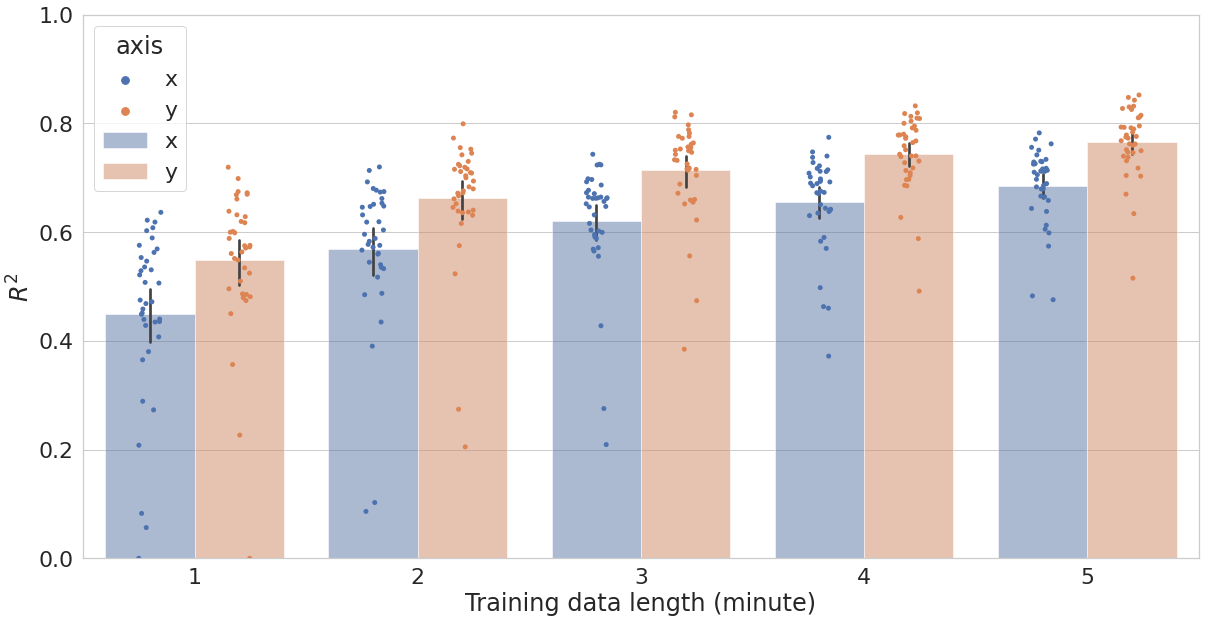

In [4]:
from statannot import add_stat_annotation

sns.set_theme(style='whitegrid', font_scale=2)
df = pd.read_csv('./results/experiments/trainingDataLength.csv')

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.barplot(ax=ax, data=df, x='trainTime', y='r_square', hue='axis', alpha=0.5)
sns.stripplot(ax=ax, data=df, x='trainTime', y='r_square', hue='axis', dodge=True)

ax.set_xlabel('Training data length (minute)')
ax.set_ylabel('$R^2$')
ax.set_ylim([0,1])

# test_results = add_stat_annotation(ax, plot='barplot', data=df, x='trainTime', y='r_square', hue='axis',
#                                    box_pairs=[((1, 'x'), (2, 'x')), ((2, 'x'), (3, 'x')), ((3, 'x'), (4, 'x')), ((4, 'x'), (5, 'x')),
#                                    ((1, 'y'), (2, 'y')), ((2, 'y'), (3, 'y')), ((3, 'y'), (4, 'y')), ((4, 'y'), (5, 'y'))],
#                                    test='Kruskal', text_format='star',
#                                    loc='outside', verbose=2)